In [141]:
import pandas as pd

ratings1 = pd.read_csv('rating.csv')  
anime1 = pd.read_csv('anime.csv')

In [142]:
ratings = ratings1[['user_id', 'anime_id', 'rating']]
anime = anime1[['anime_id', 'name']]

### Observem el dataset

In [143]:
ratings.shape

(7813737, 3)

In [144]:
anime.shape

(12294, 2)

In [145]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [146]:
anime.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   anime_id  12294 non-null  int64 
 1   name      12294 non-null  object
dtypes: int64(1), object(1)
memory usage: 192.2+ KB


In [147]:
ratings['rating'].describe()

count    7.813737e+06
mean     6.144030e+00
std      3.727800e+00
min     -1.000000e+00
25%      6.000000e+00
50%      7.000000e+00
75%      9.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

In [148]:
ratings['rating'].unique()

array([-1, 10,  8,  6,  9,  7,  3,  5,  4,  1,  2], dtype=int64)

In [149]:
ratings.isna().any()

user_id     False
anime_id    False
rating      False
dtype: bool

In [150]:
ratings['rating'].value_counts().sort_index()

rating
-1     1476496
 1       16649
 2       23150
 3       41453
 4      104291
 5      282806
 6      637775
 7     1375287
 8     1646019
 9     1254096
 10     955715
Name: count, dtype: int64

### Eliminem els -1

In [151]:
ratings = ratings[ratings['rating'] != -1]

In [152]:
ratings.shape

(6337241, 3)

### Duplicats

In [153]:
duplicates = ratings.duplicated(subset=['user_id', 'anime_id']).sum()
print(f"Número de duplicados: {duplicates}")

Número de duplicados: 7


In [154]:
duplicates2 = anime.duplicated(subset=['anime_id', 'name']).sum()
print(f"Número de duplicados: {duplicates2}")

Número de duplicados: 0


In [155]:
dup_mask = ratings.duplicated(subset=['user_id', 'anime_id'], keep=False)
ratings[dup_mask].sort_values(['user_id', 'anime_id']).head(20)

,user_id,anime_id,rating
4499243,42653,1575,8
4499286,42653,1575,6
4499244,42653,2001,8
4499288,42653,2001,10
4499255,42653,11757,8
4499307,42653,11757,5
4499258,42653,16498,8
4499316,42653,16498,8
4499261,42653,20507,7
4499320,42653,20507,9


In [156]:
# Gestionem els duplicats amb la mitjana
ratings = (
    ratings
    .groupby(['user_id', 'anime_id'], as_index=False)
    .agg({'rating': 'median'})  # con dos valores, la mediana = media
)

# Arrodonim a enter
ratings['rating'] = ratings['rating'].round().astype(int)


print("Duplicados restantes:", ratings.duplicated(subset=['user_id', 'anime_id']).sum())

Duplicados restantes: 0


In [157]:
# df = pd.merge(
#    ratings,
#    anime[['anime_id', 'name']],
#    on='anime_id',
#    how='inner'      # solo animes que aparezcan en ratings
#)

## Mirem quantes valoracions te cada anime

In [158]:
counts_per_anime = ratings['anime_id'].value_counts()
print(counts_per_anime.describe())

for p in [50, 75, 90, 95, 99]:
    print(f"P{p} =", int(counts_per_anime.quantile(p/100)))

count     9927.000000
mean       638.383600
std       1795.858567
min          1.000000
25%          9.000000
50%         57.000000
75%        395.000000
max      34226.000000
Name: count, dtype: float64
P50 = 57
P75 = 395
P90 = 1688
P95 = 3347
P99 = 8836


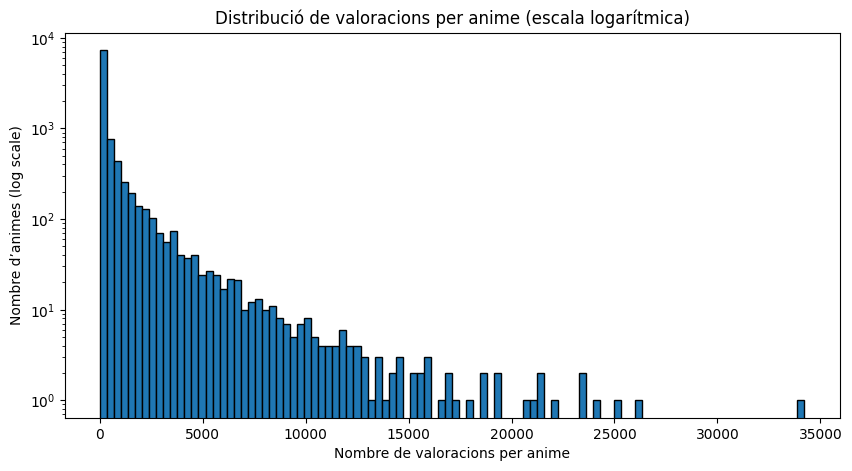

In [159]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(counts_per_anime, bins=100, edgecolor='black', log=True)
plt.title('Distribució de valoracions per anime (escala logarítmica)')
plt.xlabel('Nombre de valoracions per anime')
plt.ylabel('Nombre d’animes (log scale)')
plt.show()


In [160]:
counts_per_anime.sort_values(ascending=False).head(10)


anime_id
1535     34226
11757    26309
16498    25289
1575     24125
6547     23565
226      23528
20       22071
5114     21494
121      21332
2904     21124
Name: count, dtype: int64

In [161]:
MIN_RATINGS_ITEM = 100

valid_animes = counts_per_anime[counts_per_anime >= MIN_RATINGS_ITEM].index

# Apliquem el filtre
df_filt = ratings[ratings['anime_id'].isin(valid_animes)].copy()

# Mostrem resultats
print("Animes abans del filtre:", ratings['anime_id'].nunique())
print("Animes després del filtre:", df_filt['anime_id'].nunique())
print("Files totals després del filtre:", len(df_filt))

percentatge = len(df_filt) / len(ratings) * 100
print(f"Percentatge de files conservades: {percentatge:.2f}%")

Animes abans del filtre: 9927
Animes després del filtre: 4143
Files totals després del filtre: 6199643
Percentatge de files conservades: 97.83%


distribució molt desigual (la “cua llarga”).

## Comptem quantes valoracions té cada usuari
Los usuarios que han hecho pocas vlaoraciones tampoco contribuyen demasiado al caluclo de similitud porque no nos dan suficientes puntos de comparacion, asi que quizas se podrian filtrar.
Amb 1 sola valoració, un usuari no genera cap parella d’ítems; per tant, no aporta informació relacional. Considerem fer el tall a 5 valoracions, que aixi mantenim la majoria de dades, mirant el 25%, i aixi alhora de fer la matriu hi hauran menys files, tot i que amb 2 ja ens aporta informació.

In [162]:
counts_user = df_filt['user_id'].value_counts()

print(counts_user.describe())

for p in [50, 75, 90, 95, 99]:
    print(f"P{p} =", int(counts_user.quantile(p/100)))


count    69566.000000
mean        89.118866
std        128.568700
min          1.000000
25%         13.000000
50%         44.000000
75%        113.000000
max       2790.000000
Name: count, dtype: float64
P50 = 44
P75 = 113
P90 = 226
P95 = 326
P99 = 617


In [163]:
counts_user.sort_values(ascending=False).head(10)


user_id
42635    2790
57620    2431
59643    2342
45659    2211
7345     2209
51693    2063
65840    2046
53698    2033
22434    1787
11536    1661
Name: count, dtype: int64

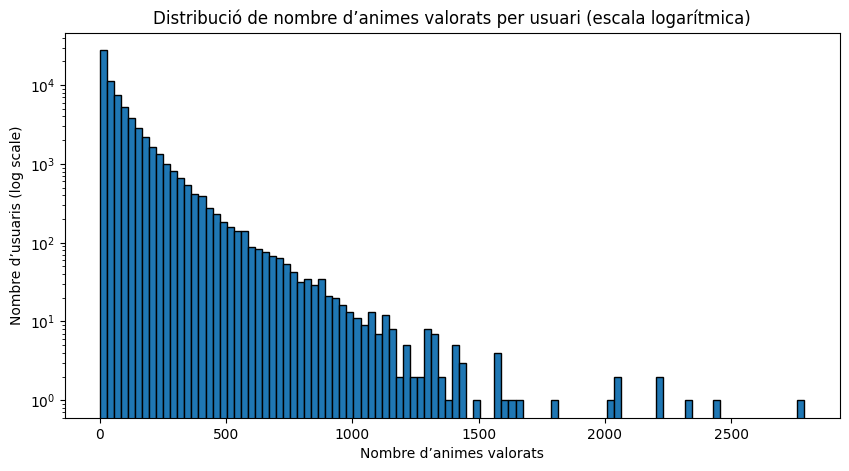

In [164]:
plt.figure(figsize=(10,5))
plt.hist(counts_user, bins=100, edgecolor='black', log=True)
plt.title('Distribució de nombre d’animes valorats per usuari (escala logarítmica)')
plt.xlabel('Nombre d’animes valorats')
plt.ylabel('Nombre d’usuaris (log scale)')
plt.show()


In [165]:
# Comptem usuaris abans del filtre
usuaris_abans = df_filt['user_id'].nunique()

# Apliquem filtre d'usuaris
MIN_RATINGS_USER = 5
counts_user = df_filt['user_id'].value_counts()
valid_users = counts_user[counts_user >= MIN_RATINGS_USER].index
df_filt = df_filt[df_filt['user_id'].isin(valid_users)].copy()

# Comptem usuaris i files després
usuaris_despres = df_filt['user_id'].nunique()
files_despres = len(df_filt)

print("Usuaris abans del filtre:", usuaris_abans)
print("Usuaris després del filtre:", usuaris_despres)
print("Files totals després del filtre:", files_despres)

# percetantge de dades que he conservat
percentatge = len(df_filt) / len(ratings) * 100
print(f"Percentatge de files conservades: {percentatge:.2f}%")


Usuaris abans del filtre: 69566
Usuaris després del filtre: 60921
Files totals després del filtre: 6180778
Percentatge de files conservades: 97.53%


Treiem els que han valorat més de 600 animes (el teu P99):

In [166]:
MAX_RATINGS_USER = counts_user.quantile(0.99)  # ≈ 617
valid_users = counts_user[
    (counts_user >= 5) &
    (counts_user <= MAX_RATINGS_USER)
].index

df_filt = df_filt[df_filt['user_id'].isin(valid_users)].copy()


In [167]:
# Comptem usuaris i files després del filtre superior
usuaris_despres2 = df_filt['user_id'].nunique()
files_despres2 = len(df_filt)

print("Usuaris després del filtre superior:", usuaris_despres2)
print("Files totals després del filtre superior:", files_despres2)

# Percentatge de files conservades respecte a l'original
percentatge2 = len(df_filt) / len(ratings) * 100
print(f"Percentatge de files conservades: {percentatge2:.2f}%")

perdua_usuaris = usuaris_abans - usuaris_despres2
print(f"Usuaris eliminats en total: {perdua_usuaris}")

Usuaris després del filtre superior: 60228
Files totals després del filtre superior: 5597916
Percentatge de files conservades: 88.33%
Usuaris eliminats en total: 9338


## Pivot table

In [168]:
# import html

# # Decodifiquem caràcters HTML en els noms d’anime
# df_filt['name'] = df_filt['name'].apply(html.unescape)

# # Comprovem que ha funcionat
# df_filt['name'].head(10)


In [169]:
userRatings = df_filt.pivot_table(
    index='user_id',
    columns='anime_id',   
    values='rating'
)

userRatings.head()

anime_id,1,5,6,7,8,15,16,17,18,19,...,33241,33338,33372,33421,33524,33558,33569,33964,34103,34240
user_id,,,,,,,,,,,,,,,,,,,,,
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,8.0,NaN,NaN,6.0,NaN,6.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [170]:
corrMatrix = userRatings.corr(method='pearson', min_periods=500)

min_periods diu quants usuaris mínims han d’haver vist tots dos animes per poder comparar-los.

Si hi ha menys usuaris en comú, no es calcula la semblança (es deixa buit).

In [171]:
corrMatrix.head()

anime_id,1,5,6,7,8,15,16,17,18,19,...,33241,33338,33372,33421,33524,33558,33569,33964,34103,34240
anime_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.524380,0.313323,0.123672,NaN,0.085844,0.232780,NaN,0.145075,0.246525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.524380,1.000000,0.310094,0.220518,NaN,NaN,0.185607,NaN,NaN,0.145550,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.313323,0.310094,1.000000,0.256794,NaN,0.321294,0.190827,NaN,0.201520,0.191706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.123672,0.220518,0.256794,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [172]:
print(corrMatrix.shape)

(4143, 4143)


In [173]:
corrMatrix[11061].sort_values(ascending=False).head(10)

anime_id
11061    1.000000
136      0.405422
18115    0.356711
14397    0.351741
14719    0.343695
28891    0.341920
137      0.340927
31964    0.336394
26055    0.334962
20899    0.332843
Name: 11061, dtype: float64

### Creem els usuaris

In [174]:
# Hunter x Hunter (2011) = 11061, School Days = 2476
myRatings = pd.Series({11061: 10, 2476: 1})


In [175]:
simCandidates = pd.Series(dtype='float64')

for anime_id, rating in myRatings.items():
    print(f"Añadiendo animes similares a {anime_id}...")

# Recuperar los animes similares a los calificadas
    sims = corrMatrix[anime_id].dropna()

# Escalar la similaridad multiplicando la correlación por la calificación del usuario
    sims = sims.map(lambda x: x * rating)

# Añadir el puntaje a la lista de candidatos similares
    simCandidates = pd.concat([simCandidates, sims])

# Mirar los resultados
print("Ordenando...")
simCandidates = simCandidates.groupby(simCandidates.index).sum()  # Sumar puntuaciones duplicadas
simCandidates.sort_values(inplace=True, ascending=False)
filteredSims = simCandidates.drop(myRatings.index)
print(filteredSims.head(10))

Añadiendo animes similares a 11061...
Añadiendo animes similares a 2476...
Ordenando...
136      4.201399
18115    3.719130
14397    3.654750
14719    3.548140
31964    3.481632
28891    3.445460
26055    3.441687
10800    3.413023
137      3.409271
15       3.406888
dtype: float64


In [176]:
# Convertir la Series en DataFrame para hacer merge
simCandidates_df = filteredSims.reset_index()
simCandidates_df.columns = ['anime_id', 'score']

# Merge con el DataFrame de animes para obtener los nombres
simCandidates_df = simCandidates_df.merge(anime, on='anime_id')

# Reordenar columnas para legibilidad
simCandidates_df = simCandidates_df[['anime_id', 'name', 'score']]

# Mostrar las 10 recomendaciones principales con nombres
simCandidates_df.head(10)

,anime_id,name,score
0,136,Hunter x Hunter,4.201399
1,18115,Magi: The Kingdom of Magic,3.719130
2,14397,Chihayafuru 2,3.654750
3,14719,JoJo no Kimyou na Bouken (TV),3.548140
4,31964,Boku no Hero Academia,3.481632
5,28891,Haikyuu!! Second Season,3.445460
6,26055,JoJo no Kimyou na Bouken: Stardust Crusaders 2...,3.441687
7,10800,Chihayafuru,3.413023
8,137,Hunter x Hunter OVA,3.409271
9,15,Eyeshield 21,3.406888
